## POS Tagging
**Using treebank corpus**

In [1]:
import numpy as np
import nltk
nltk.download('treebank')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras.utils.vis_utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Input, InputLayer, Dense, Activation, Embedding, SimpleRNN, LSTM, GRU, Bidirectional, TimeDistributed

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


### Prepare dataset

In [2]:
tagged_sentences = nltk.corpus.treebank.tagged_sents()
len(tagged_sentences)

3914

In [3]:
tagged_sentences[0]

[('Pierre', 'NNP'),
 ('Vinken', 'NNP'),
 (',', ','),
 ('61', 'CD'),
 ('years', 'NNS'),
 ('old', 'JJ'),
 (',', ','),
 ('will', 'MD'),
 ('join', 'VB'),
 ('the', 'DT'),
 ('board', 'NN'),
 ('as', 'IN'),
 ('a', 'DT'),
 ('nonexecutive', 'JJ'),
 ('director', 'NN'),
 ('Nov.', 'NNP'),
 ('29', 'CD'),
 ('.', '.')]

In [ ]:
# extract sentence and tag without seq2seq
sentences, sentence_tags =[], [] 
for tagged_sentence in tagged_sentences:
    sentence, tags = zip(*tagged_sentence)
    sentences.append([word.lower() for word in sentence])
    sentence_tags.append([tag for tag in tags])

In [4]:
# extract sentence and tag with seq2seq
sentences, sentence_tags =[], [] 
for tagged_sentence in tagged_sentences:
    sentence, tags = zip(*tagged_sentence)
    sentences.append(["startseq"]+[word.lower() for word in sentence] + ["endseq"])
    sentence_tags.append(["startseq"] + [tag for tag in tags] + ["endseq"])

In [31]:
train_sentences, test_sentences, train_tags, test_tags = train_test_split(sentences, 
                                                                          sentence_tags, 
                                                                          test_size=0.3)

In [32]:
valid_sentences, test_sentences, valid_tags, test_tags = train_test_split(test_sentences, 
                                                                          test_tags, 
                                                                          test_size=0.5)

### 2.Feature Extraction

In [7]:
# word (input word) tokenizer
word_tokenizer = Tokenizer(oov_token="<OOV>")                   
word_tokenizer.fit_on_texts(train_sentences)
train_seqs = word_tokenizer.texts_to_sequences(train_sentences)
valid_seqs = word_tokenizer.texts_to_sequences(valid_sentences)

In [8]:
max_len_word = np.max([len(seq) for seq in train_seqs])
max_len_word

273

In [9]:
vocab_size_word = len(word_tokenizer.index_word) + 1
vocab_size_word

9531

In [10]:
train_padded_seqs = pad_sequences(train_seqs, maxlen=max_len_word, padding="post")
valid_padded_seqs = pad_sequences(valid_seqs, maxlen=max_len_word, padding="post")

In [11]:
train_padded_seqs.shape, valid_padded_seqs.shape

((2739, 273), (587, 273))

In [12]:
# tag tokenizer
tag_tokenizer = Tokenizer(oov_token="<OOV>")                   
tag_tokenizer.fit_on_texts(train_tags)
train_tags = tag_tokenizer.texts_to_sequences(train_tags)
valid_tags = tag_tokenizer.texts_to_sequences(valid_tags)

In [13]:
max_len_tag = np.max([len(seq) for seq in train_tags])
max_len_tag

273

In [14]:
vocab_size_tag = len(tag_tokenizer.index_word) + 1
vocab_size_tag

50

In [15]:
train_padded_tags = pad_sequences(train_tags, maxlen=max_len_word, padding="post")
valid_padded_tags = pad_sequences(valid_tags, maxlen=max_len_word, padding="post")

In [16]:
train_padded_tags.shape, valid_padded_tags.shape

((2739, 273), (587, 273))

In [17]:
#convert to one hot encode
train_padded_tags = to_categorical(train_padded_tags, num_classes=vocab_size_tag)
valid_padded_tags = to_categorical(valid_padded_tags, num_classes=vocab_size_tag)

In [18]:
train_padded_tags.shape, valid_padded_tags.shape

((2739, 273, 50), (587, 273, 50))

### 3.Model

In [50]:
embedding_dim = 200
hidden_size   = 256
batch_size    = 512
epochs = 50

#### **RNN**

In [ ]:
model_rnn = Sequential()
model_rnn.add(InputLayer(input_shape=(max_len_word,)))
model_rnn.add(Embedding(vocab_size_word, embedding_dim))
model_rnn.add(SimpleRNN(hidden_size, return_sequences=True))
model_rnn.add(TimeDistributed(Dense(vocab_size_tag)))
model_rnn.add(Activation('softmax'))
 
model_rnn.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
model_rnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 271, 200)          1890200   
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 271, 256)          116992    
                                                                 
 time_distributed_2 (TimeDis  (None, 271, 48)          12336     
 tributed)                                                       
                                                                 
 activation_2 (Activation)   (None, 271, 48)           0         
                                                                 
Total params: 2,019,528
Trainable params: 2,019,528
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_rnn = model_rnn.fit(train_padded_seqs, train_padded_tags, 
                            batch_size=batch_size, epochs=epochs, 
                            validation_data=(valid_padded_seqs, valid_padded_tags))

Epoch 1/50
6/6 [==============================] - 2s 246ms/step - loss: 2.2629 - accuracy: 0.5739 - val_loss: 0.5752 - val_accuracy: 0.9068
Epoch 2/50
6/6 [==============================] - 1s 204ms/step - loss: 0.6462 - accuracy: 0.9035 - val_loss: 1.0766 - val_accuracy: 0.8729
Epoch 3/50
6/6 [==============================] - 1s 200ms/step - loss: 5.5273 - accuracy: 0.4797 - val_loss: 1.8684 - val_accuracy: 0.7225
Epoch 4/50
6/6 [==============================] - 1s 204ms/step - loss: 1.0937 - accuracy: 0.8426 - val_loss: 0.7511 - val_accuracy: 0.9074
Epoch 5/50
6/6 [==============================] - 1s 203ms/step - loss: 0.6696 - accuracy: 0.9073 - val_loss: 0.5041 - val_accuracy: 0.9093
Epoch 6/50
6/6 [==============================] - 1s 209ms/step - loss: 0.4786 - accuracy: 0.9080 - val_loss: 0.4323 - val_accuracy: 0.9097
Epoch 7/50
6/6 [==============================] - 1s 207ms/step - loss: 0.4203 - accuracy: 0.9081 - val_loss: 0.4033 - val_accuracy: 0.9094
Epoch 8/50
6/6 [====

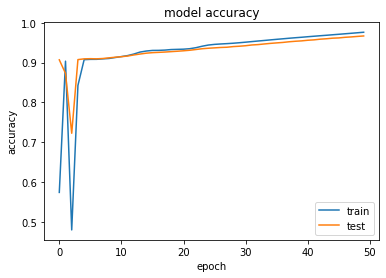

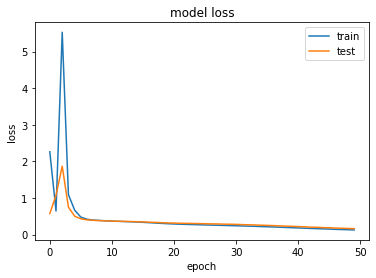

In [ ]:
# summarize history for accuracy
plt.plot(history_rnn.history['accuracy'])
plt.plot(history_rnn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

#### **LSTM**

In [ ]:
model_lstm = Sequential()
model_lstm.add(InputLayer(input_shape=(max_len_word,)))
model_lstm.add(Embedding(vocab_size_word, embedding_dim))
model_lstm.add(LSTM(hidden_size, return_sequences=True))
model_lstm.add(TimeDistributed(Dense(vocab_size_tag)))
model_lstm.add(Activation('softmax'))
 
model_lstm.compile(loss='categorical_crossentropy', 
                   optimizer='adam', 
                   metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 271, 200)          1890200   
                                                                 
 lstm (LSTM)                 (None, 271, 256)          467968    
                                                                 
 time_distributed_3 (TimeDis  (None, 271, 48)          12336     
 tributed)                                                       
                                                                 
 activation_3 (Activation)   (None, 271, 48)           0         
                                                                 
Total params: 2,370,504
Trainable params: 2,370,504
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_lstm = model_lstm.fit(train_padded_seqs, train_padded_tags, 
                             batch_size=batch_size, 
                             epochs=epochs, 
                             validation_data=(valid_padded_seqs, valid_padded_tags))

Epoch 1/50
6/6 [==============================] - 4s 206ms/step - loss: 3.1506 - accuracy: 0.7357 - val_loss: 0.4650 - val_accuracy: 0.9066
Epoch 2/50
6/6 [==============================] - 1s 124ms/step - loss: 0.5086 - accuracy: 0.9047 - val_loss: 0.5749 - val_accuracy: 0.9066
Epoch 3/50
6/6 [==============================] - 1s 122ms/step - loss: 0.5528 - accuracy: 0.9026 - val_loss: 0.4808 - val_accuracy: 0.9001
Epoch 4/50
6/6 [==============================] - 1s 126ms/step - loss: 0.4588 - accuracy: 0.9009 - val_loss: 0.4331 - val_accuracy: 0.9073
Epoch 5/50
6/6 [==============================] - 1s 126ms/step - loss: 0.4173 - accuracy: 0.9058 - val_loss: 0.4019 - val_accuracy: 0.9080
Epoch 6/50
6/6 [==============================] - 1s 123ms/step - loss: 0.3998 - accuracy: 0.9069 - val_loss: 0.3860 - val_accuracy: 0.9081
Epoch 7/50
6/6 [==============================] - 1s 118ms/step - loss: 0.3859 - accuracy: 0.9067 - val_loss: 0.3835 - val_accuracy: 0.9076
Epoch 8/50
6/6 [====

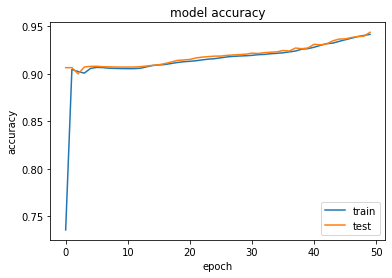

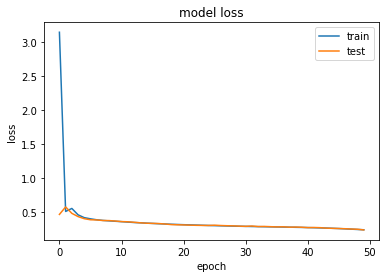

In [ ]:
# summarize history for accuracy
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

#### **GRU**

In [ ]:
model_gru = Sequential()
model_gru.add(InputLayer(input_shape=(max_len_word,)))
model_gru.add(Embedding(vocab_size_word, embedding_dim))
model_gru.add(GRU(hidden_size, return_sequences=True))
model_gru.add(TimeDistributed(Dense(vocab_size_tag)))
model_gru.add(Activation('softmax'))
 
model_gru.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
model_gru.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 271, 200)          1890200   
                                                                 
 gru (GRU)                   (None, 271, 256)          351744    
                                                                 
 time_distributed_4 (TimeDis  (None, 271, 48)          12336     
 tributed)                                                       
                                                                 
 activation_4 (Activation)   (None, 271, 48)           0         
                                                                 
Total params: 2,254,280
Trainable params: 2,254,280
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_gru = model_gru.fit(train_padded_seqs, train_padded_tags, 
                             batch_size=batch_size, 
                             epochs=epochs, 
                             validation_data=(valid_padded_seqs, valid_padded_tags))

Epoch 1/50
6/6 [==============================] - 2s 184ms/step - loss: 3.4691 - accuracy: 0.7361 - val_loss: 2.3078 - val_accuracy: 0.9066
Epoch 2/50
6/6 [==============================] - 1s 112ms/step - loss: 1.0519 - accuracy: 0.9047 - val_loss: 0.6158 - val_accuracy: 0.9066
Epoch 3/50
6/6 [==============================] - 1s 104ms/step - loss: 0.6173 - accuracy: 0.9049 - val_loss: 0.3815 - val_accuracy: 0.9099
Epoch 4/50
6/6 [==============================] - 1s 107ms/step - loss: 0.3822 - accuracy: 0.9138 - val_loss: 0.3809 - val_accuracy: 0.9114
Epoch 5/50
6/6 [==============================] - 1s 102ms/step - loss: 0.3904 - accuracy: 0.9075 - val_loss: 0.3797 - val_accuracy: 0.9091
Epoch 6/50
6/6 [==============================] - 1s 106ms/step - loss: 0.3861 - accuracy: 0.9072 - val_loss: 0.3738 - val_accuracy: 0.9109
Epoch 7/50
6/6 [==============================] - 1s 102ms/step - loss: 0.3793 - accuracy: 0.9093 - val_loss: 0.3675 - val_accuracy: 0.9160
Epoch 8/50
6/6 [====

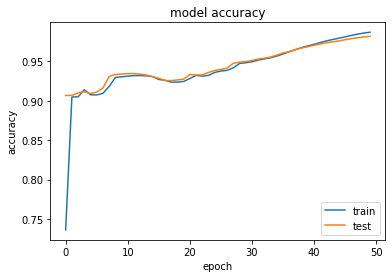

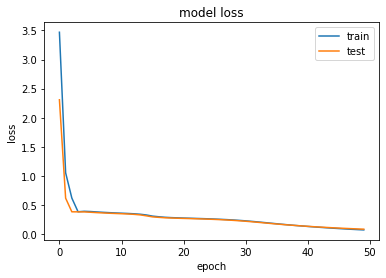

In [ ]:
# summarize history for accuracy
plt.plot(history_gru.history['accuracy'])
plt.plot(history_gru.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

#### **Bidirectional GRU**

In [ ]:
model_bigru = Sequential()
model_bigru.add(InputLayer(input_shape=(max_len_word,)))
model_bigru.add(Embedding(vocab_size_word, embedding_dim))
model_bigru.add(Bidirectional(GRU(hidden_size, return_sequences=True)))
model_bigru.add(TimeDistributed(Dense(vocab_size_tag)))
model_bigru.add(Activation('softmax'))
 
model_bigru.compile(loss='categorical_crossentropy', 
                    optimizer='adam', 
                    metrics=['accuracy'])
model_bigru.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 271, 200)          1890200   
                                                                 
 bidirectional (Bidirectiona  (None, 271, 512)         703488    
 l)                                                              
                                                                 
 time_distributed_5 (TimeDis  (None, 271, 48)          24624     
 tributed)                                                       
                                                                 
 activation_5 (Activation)   (None, 271, 48)           0         
                                                                 
Total params: 2,618,312
Trainable params: 2,618,312
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_bigru = model_bigru.fit(train_padded_seqs, train_padded_tags, 
                             batch_size=batch_size, 
                             epochs=epochs, 
                             validation_data=(valid_padded_seqs, valid_padded_tags))

Epoch 1/50
6/6 [==============================] - 5s 316ms/step - loss: 3.2944 - accuracy: 0.7358 - val_loss: 1.6518 - val_accuracy: 0.9066
Epoch 2/50
6/6 [==============================] - 1s 191ms/step - loss: 0.7820 - accuracy: 0.9047 - val_loss: 0.5513 - val_accuracy: 0.9066
Epoch 3/50
6/6 [==============================] - 1s 187ms/step - loss: 0.4395 - accuracy: 0.9069 - val_loss: 0.3600 - val_accuracy: 0.9215
Epoch 4/50
6/6 [==============================] - 1s 189ms/step - loss: 0.3690 - accuracy: 0.9153 - val_loss: 0.3632 - val_accuracy: 0.9131
Epoch 5/50
6/6 [==============================] - 1s 188ms/step - loss: 0.3706 - accuracy: 0.9108 - val_loss: 0.3606 - val_accuracy: 0.9143
Epoch 6/50
6/6 [==============================] - 1s 187ms/step - loss: 0.3658 - accuracy: 0.9152 - val_loss: 0.3537 - val_accuracy: 0.9262
Epoch 7/50
6/6 [==============================] - 1s 187ms/step - loss: 0.3577 - accuracy: 0.9308 - val_loss: 0.3454 - val_accuracy: 0.9333
Epoch 8/50
6/6 [====

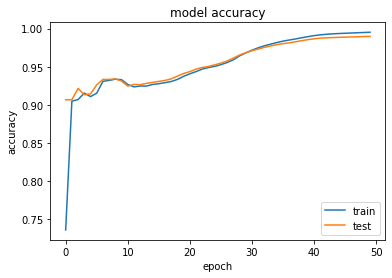

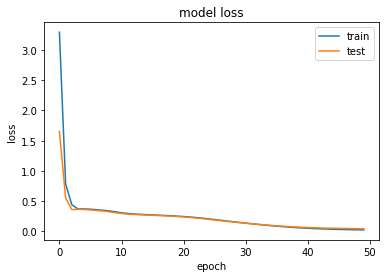

In [ ]:
# summarize history for accuracy
plt.plot(history_bigru.history['accuracy'])
plt.plot(history_bigru.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history_bigru.history['loss'])
plt.plot(history_bigru.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

#### **Stacked GRU**

In [ ]:
model_stackgru = Sequential()
model_stackgru.add(InputLayer(input_shape=(max_len_word,)))
model_stackgru.add(Embedding(vocab_size_word, embedding_dim))
model_stackgru.add(GRU(hidden_size, return_sequences=True))
model_stackgru.add(GRU(hidden_size, return_sequences=True))
model_stackgru.add(TimeDistributed(Dense(vocab_size_tag)))
model_stackgru.add(Activation('softmax'))
 
model_stackgru.compile(loss='categorical_crossentropy', 
                       optimizer='adam', 
                       metrics=['accuracy'])
model_stackgru.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 271, 200)          1890200   
                                                                 
 gru_2 (GRU)                 (None, 271, 256)          351744    
                                                                 
 gru_3 (GRU)                 (None, 271, 256)          394752    
                                                                 
 time_distributed_6 (TimeDis  (None, 271, 48)          12336     
 tributed)                                                       
                                                                 
 activation_6 (Activation)   (None, 271, 48)           0         
                                                                 
Total params: 2,649,032
Trainable params: 2,649,032
Non-trainable params: 0
____________________________________________

In [ ]:
history_stackgru = model_stackgru.fit(train_padded_seqs, train_padded_tags, 
                             batch_size=batch_size, 
                             epochs=epochs, 
                             validation_data=(valid_padded_seqs, valid_padded_tags))

Epoch 1/50
6/6 [==============================] - 4s 301ms/step - loss: 3.0735 - accuracy: 0.7357 - val_loss: 0.4231 - val_accuracy: 0.9066
Epoch 2/50
6/6 [==============================] - 1s 182ms/step - loss: 0.5300 - accuracy: 0.9047 - val_loss: 0.5206 - val_accuracy: 0.9066
Epoch 3/50
6/6 [==============================] - 1s 178ms/step - loss: 0.4166 - accuracy: 0.9053 - val_loss: 0.3923 - val_accuracy: 0.9066
Epoch 4/50
6/6 [==============================] - 1s 182ms/step - loss: 0.4053 - accuracy: 0.9046 - val_loss: 0.3906 - val_accuracy: 0.9082
Epoch 5/50
6/6 [==============================] - 1s 184ms/step - loss: 0.3915 - accuracy: 0.9069 - val_loss: 0.3721 - val_accuracy: 0.9091
Epoch 6/50
6/6 [==============================] - 1s 184ms/step - loss: 0.3748 - accuracy: 0.9078 - val_loss: 0.3617 - val_accuracy: 0.9121
Epoch 7/50
6/6 [==============================] - 1s 181ms/step - loss: 0.3664 - accuracy: 0.9125 - val_loss: 0.3566 - val_accuracy: 0.9177
Epoch 8/50
6/6 [====

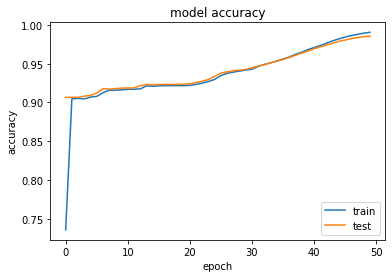

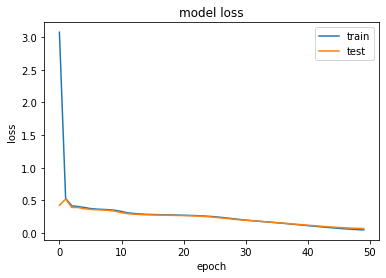

In [ ]:
# summarize history for accuracy
plt.plot(history_stackgru.history['accuracy'])
plt.plot(history_stackgru.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history_stackgru.history['loss'])
plt.plot(history_stackgru.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### 4.Encoder-Decoder
**Seq2Seq**
Example:

**Feature Extraction**
- Encoder input data

In [25]:
# word (input word) tokenizer
word_tokenizer = Tokenizer(oov_token="<OOV>")                   
word_tokenizer.fit_on_texts(train_sentences)
train_seqs = word_tokenizer.texts_to_sequences(train_sentences)
valid_seqs = word_tokenizer.texts_to_sequences(valid_sentences)

In [26]:
max_len_word = np.max([len(seq) for seq in train_seqs])
vocab_size_word = len(word_tokenizer.index_word) + 1
vocab_size_word, max_len_word

(9458, 273)

In [52]:
train_input_padded_seqs = pad_sequences(train_seqs, maxlen=max_len_word, padding="post")
valid_input_padded_seqs = pad_sequences(valid_seqs, maxlen=max_len_word, padding="post")
train_input_padded_seqs.shape, valid_padded_seqs.shape

((2739, 273), (587, 273))

- Decoder input data

In [33]:
# tag tokenizer
tag_tokenizer = Tokenizer(oov_token="<OOV>")                   
tag_tokenizer.fit_on_texts(train_tags)
train_input_tags = tag_tokenizer.texts_to_sequences(train_tags)
valid_input_tags = tag_tokenizer.texts_to_sequences(valid_tags)

In [36]:
max_len_tag = np.max([len(seq) for seq in train_input_tags])
vocab_size_tag = len(tag_tokenizer.index_word) + 1
vocab_size_tag, max_len_tag

(50, 273)

In [46]:
train_input_padded_tags = pad_sequences(train_input_tags, maxlen=max_len_tag, padding="post")
valid_input_padded_tags = pad_sequences(valid_input_tags, maxlen=max_len_tag, padding="post")
train_input_padded_tags.shape, valid_input_padded_tags.shape

((2739, 273), (587, 273))

- Decoder target data

In [43]:
train_target_tags = [i[1:] for i in train_tags]
valid_target_tags = [i[1:] for i in valid_tags]

In [44]:
train_target_tags = tag_tokenizer.texts_to_sequences(train_target_tags)
valid_target_tags = tag_tokenizer.texts_to_sequences(valid_target_tags)

In [65]:
train_target_padded_tags = pad_sequences(train_target_tags, maxlen=max_len_tag, padding="post")
valid_target_padded_tags = pad_sequences(valid_target_tags, maxlen=max_len_tag, padding="post")
train_target_padded_tags.shape, valid_target_padded_tags.shape

((2739, 273), (587, 273))

In [48]:
#convert to one hot encode
train_target_padded_tags = to_categorical(train_target_padded_tags, num_classes = vocab_size_tag)
valid_target_padded_tags = to_categorical(valid_target_padded_tags, num_classes = vocab_size_tag)
train_target_padded_tags.shape, valid_target_padded_tags.shape

((2739, 273, 50), (587, 273, 50))

In [67]:
train_input_padded_tags, train_target_padded_tags, train_input_padded_seqs

(array([[10,  3,  5, ...,  0,  0,  0],
        [10,  5, 13, ...,  0,  0,  0],
        [10,  3, 15, ...,  0,  0,  0],
        ...,
        [10, 15, 15, ...,  0,  0,  0],
        [10,  3,  7, ...,  0,  0,  0],
        [10, 21, 24, ...,  0,  0,  0]], dtype=int32),
 array([[ 3,  5,  8, ...,  0,  0,  0],
        [ 5, 13,  7, ...,  0,  0,  0],
        [ 3, 15,  9, ...,  0,  0,  0],
        ...,
        [15, 15,  9, ...,  0,  0,  0],
        [ 3,  7,  9, ...,  0,  0,  0],
        [21, 24, 16, ...,  0,  0,  0]], dtype=int32),
 array([[  4,  29, 889, ...,   0,   0,   0],
        [  4, 301, 890, ...,   0,   0,   0],
        [  4,  10, 383, ...,   0,   0,   0],
        ...,
        [  4,   3, 120, ...,   0,   0,   0],
        [  4,  11,  25, ...,   0,   0,   0],
        [  4,  32,   3, ...,   0,   0,   0]], dtype=int32))

**Seq2Seq Model**

In [58]:
encoder_inputs = Input(shape=(max_len_word,))
encoder_embedding = Embedding(vocab_size_word, embedding_dim , mask_zero=True)(encoder_inputs)
encoder_outputs, state_h, state_c = LSTM(hidden_size, return_state=True)(encoder_embedding)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(max_len_tag,))
decoder_embedding = Embedding(vocab_size_tag, embedding_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(hidden_size, return_state=True, return_sequences=True)
decoder_outputs , _ , _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(vocab_size_tag, Activation('softmax')) 
output = decoder_dense(decoder_outputs)

seq2seq_model = Model(inputs=[encoder_inputs, decoder_inputs], 
                      outputs=output)

seq2seq_model.compile(loss='categorical_crossentropy', 
                      optimizer='adam', 
                      metrics=['accuracy'])
seq2seq_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 273)]        0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 273)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 273, 200)     1891600     ['input_6[0][0]']                
                                                                                                  
 embedding_5 (Embedding)        (None, 273, 200)     10000       ['input_7[0][0]']                
                                                                                            

In [60]:
history_seq2seq = seq2seq_model.fit([train_input_padded_seqs , train_input_padded_tags], 
                                    train_target_padded_tags, 
                                    batch_size=batch_size, 
                                    epochs=200, 
                                    validation_data=([valid_input_padded_seqs , valid_input_padded_tags], 
                                                      valid_target_padded_tags))

Epoch 1/200
6/6 [==============================] - 1s 105ms/step - loss: 0.1969 - accuracy: 0.4204 - val_loss: 0.1975 - val_accuracy: 0.4107
Epoch 2/200
6/6 [==============================] - 1s 86ms/step - loss: 0.1966 - accuracy: 0.4219 - val_loss: 0.1973 - val_accuracy: 0.4108
Epoch 3/200
6/6 [==============================] - 0s 81ms/step - loss: 0.1961 - accuracy: 0.4224 - val_loss: 0.1969 - val_accuracy: 0.4101
Epoch 4/200
6/6 [==============================] - 0s 83ms/step - loss: 0.1957 - accuracy: 0.4232 - val_loss: 0.1968 - val_accuracy: 0.4121
Epoch 5/200
6/6 [==============================] - 0s 82ms/step - loss: 0.1953 - accuracy: 0.4250 - val_loss: 0.1965 - val_accuracy: 0.4122
Epoch 6/200
6/6 [==============================] - 0s 84ms/step - loss: 0.1955 - accuracy: 0.4243 - val_loss: 0.1978 - val_accuracy: 0.4092
Epoch 7/200
6/6 [==============================] - 0s 84ms/step - loss: 0.1958 - accuracy: 0.4232 - val_loss: 0.1971 - val_accuracy: 0.4118
Epoch 8/200
6/6 [==

KeyboardInterrupt: ignored

### 5.Compare RNN, LSTM, GRU, Stacked-GRU, Bi-GRU

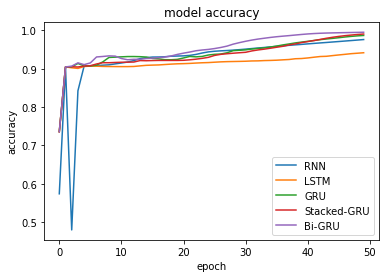

In [ ]:
plt.plot(history_rnn.history['accuracy'])
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_gru.history['accuracy'])
plt.plot(history_stackgru.history['accuracy'])
plt.plot(history_bigru.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['RNN', 'LSTM', 'GRU', 'Stacked-GRU', 'Bi-GRU'], loc='lower right')
plt.show()

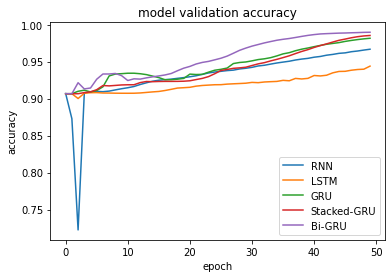

In [ ]:
plt.plot(history_rnn.history['val_accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.plot(history_gru.history['val_accuracy'])
plt.plot(history_stackgru.history['val_accuracy'])
plt.plot(history_bigru.history['val_accuracy'])
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['RNN', 'LSTM', 'GRU', 'Stacked-GRU', 'Bi-GRU'], loc='lower right')
plt.show()

### 6.Predict

In [ ]:
def pos_tag_predict(text, max_len_word, model, word_tokenizer, tag_tokenizer):
    test_seq = word_tokenizer.texts_to_sequences([text])
    test_padded_seq = pad_sequences(test_seq, maxlen=max_len_word, padding="post")
    tag_predict = model.predict(test_padded_seq)

    token_sequences = []
    for categorical_sequence in tag_predict[0]:
        idx_tag = np.argmax(categorical_sequence)
        if idx_tag not in [0, 1]:
            tag = tag_tokenizer.index_word[idx_tag]
            token_sequences.append(tag.upper())
    return token_sequences

In [ ]:
text = "I was running every day for a month ."
pos_tag_predict(text.lower().split(), max_len_word, model_rnn, word_tokenizer, tag_tokenizer)

['PRP', 'VBD', 'RB', 'DT', 'NN', 'IN', 'DT', 'NN', '.']

In [ ]:
idx = 0
predict_tags = pos_tag_predict(test_sentences[idx], max_len_word, model_rnn, word_tokenizer, tag_tokenizer)
target_tags = test_tags[idx]
" ".join(predict_tags), " ".join(target_tags)

('NNS NN NN NN -NONE- TO VB DT NN NNS IN DT NN NN DT NN . .',
 'NNS VBP NN NN -NONE- TO VB DT NN NNS IN DT NN CC DT NN .')

In [ ]:
idx = 0
predict_tags = pos_tag_predict(test_sentences[idx], max_len_word, model_lstm, word_tokenizer, tag_tokenizer)
target_tags = test_tags[idx]
" ".join(predict_tags), " ".join(target_tags)

('DT NN NN NN NN NN DT NN NN IN DT NN NN DT NN .',
 'NNS VBP NN NN -NONE- TO VB DT NN NNS IN DT NN CC DT NN .')

In [ ]:
idx = 0
predict_tags = pos_tag_predict(test_sentences[idx], max_len_word, model_gru, word_tokenizer, tag_tokenizer)
target_tags = test_tags[idx]
" ".join(predict_tags), " ".join(target_tags)

('NNS NN NN NN -NONE- TO VB DT NN NNS IN DT JJ CC DT NN .',
 'NNS VBP NN NN -NONE- TO VB DT NN NNS IN DT NN CC DT NN .')

In [ ]:
idx = 0
predict_tags = pos_tag_predict(test_sentences[idx], max_len_word, model_stackgru, word_tokenizer, tag_tokenizer)
target_tags = test_tags[idx]
" ".join(predict_tags), " ".join(target_tags)

('. IN NNP NN -NONE- TO VB DT NN NNS IN DT JJ CC DT NN .',
 'NNS VBP NN NN -NONE- TO VB DT NN NNS IN DT NN CC DT NN .')

In [ ]:
idx = 0
predict_tags = pos_tag_predict(test_sentences[idx], max_len_word, model_bigru, word_tokenizer, tag_tokenizer)
target_tags = test_tags[idx]
" ".join(predict_tags), " ".join(target_tags)

('NNS VBP NN NN -NONE- TO VB DT NN NNS IN DT JJ CC DT NN .',
 'NNS VBP NN NN -NONE- TO VB DT NN NNS IN DT NN CC DT NN .')